I gave up on curl/wget and uploaded all the files to jupyterlab

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
cap = cv2.VideoCapture("jgrf217-sup-0006-ms05.avi")

In [23]:
fc = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frames = np.zeros((int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), \
                   int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), \
                   int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), 3), np.dtype('uint8'))
fc

321

In [24]:
fidx = 0
ret = True

while (fidx < fc  and ret):
    ret, frames[fidx] = cap.read()
    frames[fidx] = cv2.cvtColor(frames[fidx],cv2.COLOR_BGR2RGB)
    fidx += 1

cap.release()

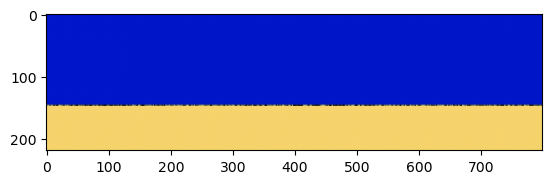

In [43]:
plt.imshow(frames[0]) #(frame)

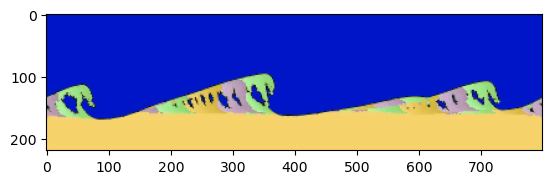

In [72]:
plt.imshow(frames[-1])#(lastframe)

In [50]:
frames[-1,:,300,0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   0,
         9,   2, 124, 117, 188, 188, 189, 189, 188, 188, 189, 189, 189,
       187, 149, 145, 189, 185, 189, 185, 188, 187, 178, 173,  44,  37,
         3,   0,  22,  17,  56,  56, 162, 162, 183, 183, 197, 197, 198,
       198, 197, 197, 198, 198, 196, 196, 191, 191, 195, 195, 195, 195,
       199, 200, 240, 240, 242, 242, 243, 243, 248, 248, 247, 247, 248,
       248, 247, 247, 248, 248, 247, 247, 248, 248, 247, 247, 24

Check if sum() creates a smooth plot. Also avoids differencing from `frame.shape[1]`

In [154]:
coastlines = np.array([(frames[frame,:,:,0]>25).sum(axis=0) for frame in range(fc)])

In [155]:
coastlines.shape

(321, 799)

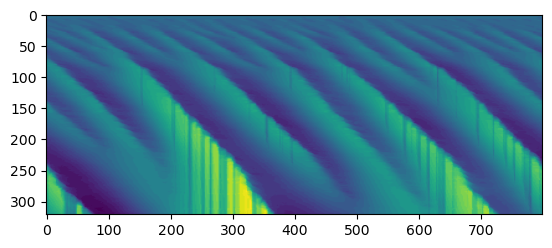

In [156]:
plt.imshow(coastlines)

Hm, I guess the embayments create vertical streaks. It's not very smooth/pretty. Let's try `frames.shape[1]-argmax()`

In [178]:
frames.shape

(321, 219, 799, 3)

In [179]:
coastlines = np.array([frames.shape[1]-(frames[frame,:,:,0]>25).argmax(axis=0) for frame in range(fc)])

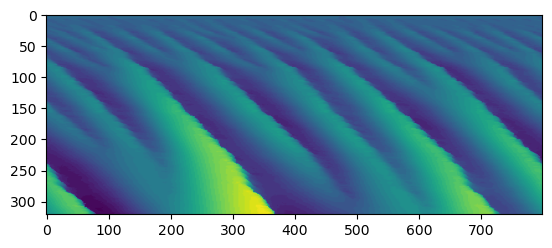

In [180]:
plt.imshow(coastlines)

This is probably an ok representation of CoastSat. It also reflects wave shadowing (by ignoring those sections of coast)

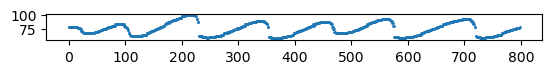

In [182]:
plt.scatter(np.array(range(coastlines.shape[1])),coastlines[160],s=1)
plt.gca().set_aspect('equal')

Let's try plotting the embayments and little holes. Let's find one and check what color it is.

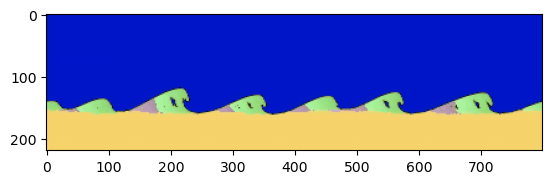

In [42]:
plt.imshow(frames[160])#(lastframe)

In [46]:
frames[160,:,190,0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  13,   6, 102, 102, 164, 164,
       164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164,
       164, 164, 164, 164, 164, 133, 130, 172, 168, 166, 166, 167, 167,
       185, 185, 187, 187, 236, 236, 234, 234, 247, 247, 246, 246, 247,
       247, 246, 246, 247, 247, 246, 246, 247, 247, 246, 246, 24

So it looks like the boundary pixels have red values around 90-140

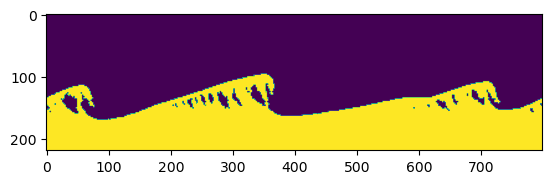

In [144]:
plt.imshow(frames[-1,:,:,0]>100)#(lastframe)

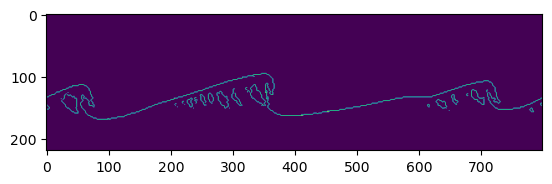

In [ ]:
edges = cv2.Canny((frames[-1,:,:,0]>100).astype('uint8'), 0, 0) # No higher thresholds work
plt.imshow(edges)

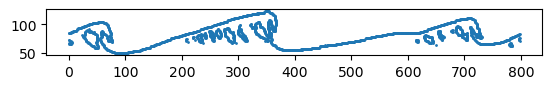

In [ ]:
plt.scatter(*np.flip(edges.T,axis=1).nonzero(),s=1)
plt.gca().set_aspect('equal')

Let's try for just open embayments without the enclosed ones (i.e. little holes)

In [148]:
# Needs to be <, or else it just finds two components (land and ocean)
data = frames[-1,:,:,0]<100
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(data.astype('uint8'), connectivity=8)

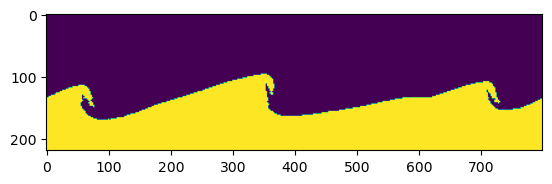

In [151]:
# This could use area with stats[:,-1], but theoretically land could be bigger, \
# so I match leftmost and topmost coordinates to 0,0 to ensure we pick the ocean component
data[output!=(stats[:,:2]==[0,0]).all(axis=1).argmax()] = 0 # zero because of using < (less than)
plt.imshow(~data) # ~ inverts (to match previous plots)

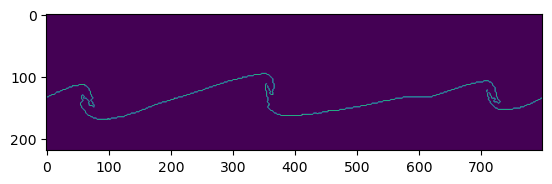

In [152]:
edges = cv2.Canny((~data).astype('uint8'), 0, 0) # No higher thresholds work
plt.imshow(edges)

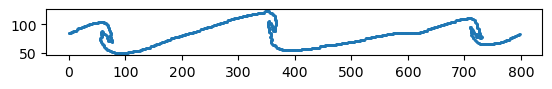

In [153]:
plt.scatter(*np.flip(edges.T,axis=1).nonzero(),s=1)
plt.gca().set_aspect('equal')

In [215]:
def findcoasts(frame,red=100,openCoastsOnly=False):
    # Needs to be <, or else it just finds two components (land and ocean)
    data = frames[frame,:,:,0]<red
    if openCoastsOnly:
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(data.astype('uint8'), connectivity=8)
        # This could use area with stats[:,-1], but theoretically land could be bigger, \
        # so I match leftmost and topmost coordinates to 0,0 to ensure we pick the ocean component
        data[output!=(stats[:,:2]==[0,0]).all(axis=1).argmax()] = 0 # zero because of using < (less than)
    edges = cv2.Canny((~data).astype('uint8'), 0, 0) # No higher thresholds work
    return np.array(np.flip(edges.T,axis=1).nonzero()).T

In [191]:
np.array(findcoasts(-1))

array([[  0,   0,   0, ..., 798, 798, 798],
       [ 67,  73,  85, ...,  71,  75,  83]])

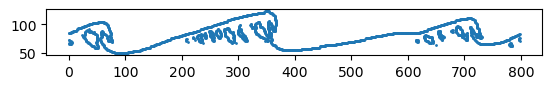

In [195]:
plt.scatter(*findcoasts(-1),s=1)
plt.gca().set_aspect('equal')

In [198]:
coastlinesPC = [findcoasts(frame) for frame in range(fc)]

In [200]:
max([f.shape[1] for f in coastlinesPC])

1694

In [ ]:
def writePts2Txt(x,y,filename):
    with open(filename, "w") as file:
        for index in range(len(x)):
            file.write(str(x[index]) + " " + str(y[index]) + "\n")
        file.seek(file.tell() - 1, 0)
        file.truncate()

def appendPts2Txt(x,y,filename):
    with open(filename, "a") as file:
        file.write(str("\n\n"))
        for index in range(len(x)):
            file.write(str(x[index]) + " " + str(y[index]) + "\n")
        file.seek(file.tell() - 1, 0)
        file.truncate()

https://stackoverflow.com/a/36570522


In [207]:
np.savez_compressed('test',*coastlinesPC)

In [210]:
readin = np.load('test.npz')

In [211]:
readin

NpzFile 'test.npz' with keys: arr_0, arr_1, arr_2, arr_3, arr_4...

In [218]:
[readin[key] for key in readin.keys()]

[array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  72, ...,  73,  72,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 73,  72,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 69,  69,  69, ...,  71,  70,  69]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 69,  69,  69, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  73,  

In [244]:
readin.close()

In [219]:
coastlinesPC

[array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  72, ...,  73,  72,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 73,  72,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 69,  69,  69, ...,  71,  70,  69]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 69,  69,  69, ...,  71,  71,  71]]),
 array([[  0,   1,   2, ..., 796, 797, 798],
        [ 71,  71,  71, ...,  73,  

In [213]:
np.loadtxt('topology-project/data/spit.txt')

array([[  -0.        ,  -42.09257965],
       [  -1.16618157,  -42.22915591],
       [  -2.27272798,  -42.23412721],
       [  -3.25030425,  -42.14297923],
       [  -4.25761838,  -42.05462549],
       [  -5.16783549,  -41.8821476 ],
       [  -5.93724706,  -41.7714402 ],
       [  -6.67000878,  -41.61144853],
       [  -7.41153702,  -41.46416084],
       [  -8.16168722,  -41.32728342],
       [  -8.77461389,  -41.24087295],
       [  -9.43422687,  -41.16844935],
       [ -10.01403243,  -41.04628646],
       [ -10.7171768 ,  -41.00099345],
       [ -11.36101464,  -40.99428852],
       [ -12.16548647,  -40.90763565],
       [ -13.12893214,  -40.83916024],
       [ -14.03372043,  -40.85217446],
       [ -14.95756896,  -40.82197896],
       [ -15.89900082,  -40.70043452],
       [ -16.79229331,  -40.58036688],
       [ -17.80651317,  -40.35466037],
       [ -18.73431372,  -40.09083339],
       [ -19.68610418,  -39.7632598 ],
       [ -20.69934638,  -39.32445869],
       [ -21.81297894,  -

In [235]:
import cv2
import numpy as np
# from PIL import Image

In [222]:
def findcoasts(frame,red=100,openCoastsOnly=False):
    # Needs to be <, or else it just finds two components (land and ocean)
    # Here, frame is passed in as 3d array
    data = frame[:,:,0]<red
    if openCoastsOnly:
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(data.astype('uint8'), connectivity=8)
        # This could use area with stats[:,-1], but theoretically land could be bigger, \
        # so I match leftmost and topmost coordinates to 0,0 to ensure we pick the ocean component
        data[output!=(stats[:,:2]==[0,0]).all(axis=1).argmax()] = 0 # zero because of using < (less than)
    edges = cv2.Canny((~data).astype('uint8'), 0, 0) # No higher thresholds work
    return np.array(np.flip(edges.T,axis=1).nonzero()).T

In [243]:
for fnum in range(1,6):
    fnBase = f"jgrf217-sup-000{fnum+1}-ms0{fnum}"
    print(fnBase)
    cap = cv2.VideoCapture(fnBase+".avi")
    fc = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = np.zeros((int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), \
                       int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), \
                       int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), 3), np.dtype('uint8'))
    print(fc)

    fidx = 0
    ret = True
    while (fidx < fc  and ret):
        ret, frames[fidx] = cap.read()
        frames[fidx] = cv2.cvtColor(frames[fidx],cv2.COLOR_BGR2RGB)
        fidx += 1
    cap.release()
    
    # For good measure, save the pretty argmax plots as png
    imArr = np.array([frames.shape[1]-(frames[frame,:,:,0]>25).argmax(axis=0) for frame in range(fc)])
    #Image.fromarray(255*imArr/imArr.max(), 'L').save(fnBase+".png")
    cv2.imwrite(fnBase+".png",cv2.applyColorMap((255*imArr/imArr.max()).astype('uint8'),16))

    np.savez_compressed(fnBase,*[findcoasts(frames[frame]) for frame in range(fc)])

jgrf217-sup-0002-ms01
320
jgrf217-sup-0003-ms02
321
jgrf217-sup-0004-ms03
321
jgrf217-sup-0005-ms04
321
jgrf217-sup-0006-ms05
321


In [245]:
coasts = dict()
for fnum in range(1,6):
    fnBase = f"jgrf217-sup-000{fnum+1}-ms0{fnum}"
    readin = np.load(fnBase+".npz")
    coasts[fnBase] = [readin[key] for key in readin.keys()]
    readin.close()

In [258]:
videoNum = 0
timestep = 0
coasts[list(coasts.keys())[videoNum]][timestep]

array([[  0,  73],
       [  1,  73],
       [  2,  73],
       ...,
       [797,  72],
       [798,  70],
       [798,  73]])